# Home 4: Build a CNN for image recognition.

### Name: [Tianyi Li]


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM4/HM4.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [56]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))


shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [57]:
import numpy as np

def to_one_hot(y, num_class=10):
  #<fill the function>
  results = np.zeros((len(y), num_class))
  for i, y in enumerate(y):
    results[i, y] = 1
  return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [107]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [123]:
from keras.layers import *
from keras.models import Model,Sequential

# network structure 1(showing better performance in tuning): simple ResNet-like network
def CNNModel1():
  inputx = Input(shape=(32, 32, 3))
  # block_1
  layer = Conv2D(64, (3, 3),padding='same')(inputx)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  layer = Conv2D(64, (7, 7),padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  block_1_output = MaxPooling2D((2, 2))(layer)
  # block_2
  layer = Dropout(0.5)(block_1_output)
  layer = Conv2D(64, (3, 3),padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  layer = Conv2D(64, (7, 7),padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  block_2_output = add([layer, block_1_output])
  # last
  layer = Flatten()(block_2_output)
  layer = Dropout(0.5)(layer)
  layer = Dense(128)(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  outputx = Dense(10, activation='softmax')(layer)
  model = Model(inputx, outputx)

  return model

# network structure 2: modified on original code
def CNNModel2():
  model = Sequential()
  model.add(Conv2D(32, (3, 3),padding='same', input_shape=(32, 32, 3))) # add
  model.add(BatchNormalization()) # add
  model.add(Activation('relu')) # add
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3),padding='same'))  # add
  model.add(BatchNormalization()) # add
  model.add(Activation('relu')) # add
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3),padding='same'))  # add
  model.add(BatchNormalization()) # add
  model.add(Activation('relu')) # add
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dropout(0.5)) # add
  model.add(Dense(128))
  model.add(BatchNormalization()) # add
  model.add(Activation('relu')) # add
  model.add(Dense(10, activation='softmax'))

  return model

model = CNNModel1()
model.summary()
model = CNNModel2()
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_236 (Conv2D)             (None, 32, 32, 64)   1792        input_62[0][0]                   
__________________________________________________________________________________________________
batch_normalization_267 (BatchN (None, 32, 32, 64)   256         conv2d_236[0][0]                 
__________________________________________________________________________________________________
activation_267 (Activation)     (None, 32, 32, 64)   0           batch_normalization_267[0][0]    
___________________________________________________________________________________________

When learning_rate = 0.000010:
  When mode is CNNModel1:
Epoch 1/20
1250/1250 [==============================] - 20s 15ms/step - loss: 2.1704 - acc: 0.2291 - val_loss: 1.6369 - val_acc: 0.4176
Epoch 2/20
1250/1250 [==============================] - 19s 15ms/step - loss: 1.6828 - acc: 0.3940 - val_loss: 1.4909 - val_acc: 0.4658
Epoch 3/20
1250/1250 [==============================] - 18s 15ms/step - loss: 1.5294 - acc: 0.4515 - val_loss: 1.4014 - val_acc: 0.4973
Epoch 4/20
1250/1250 [==============================] - 18s 15ms/step - loss: 1.4246 - acc: 0.4889 - val_loss: 1.3382 - val_acc: 0.5202
Epoch 5/20
1250/1250 [==============================] - 18s 15ms/step - loss: 1.3546 - acc: 0.5179 - val_loss: 1.2800 - val_acc: 0.5418
Epoch 6/20
1250/1250 [==============================] - 18s 15ms/step - loss: 1.2886 - acc: 0.5438 - val_loss: 1.2456 - val_acc: 0.5557
Epoch 7/20
1250/1250 [==============================] - 18s 15ms/step - loss: 1.2523 - acc: 0.5570 - val_loss: 1.2049 - val_acc

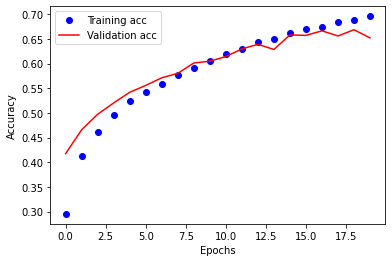

  When mode is CNNModel2:
Epoch 1/20
1250/1250 [==============================] - 8s 5ms/step - loss: 2.4740 - acc: 0.1431 - val_loss: 1.9206 - val_acc: 0.3200
Epoch 2/20
1250/1250 [==============================] - 6s 5ms/step - loss: 2.0567 - acc: 0.2571 - val_loss: 1.7729 - val_acc: 0.3645
Epoch 3/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.9066 - acc: 0.3096 - val_loss: 1.6885 - val_acc: 0.3971
Epoch 4/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8194 - acc: 0.3422 - val_loss: 1.6276 - val_acc: 0.4187
Epoch 5/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.7507 - acc: 0.3699 - val_loss: 1.5765 - val_acc: 0.4396
Epoch 6/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6973 - acc: 0.3908 - val_loss: 1.5329 - val_acc: 0.4537
Epoch 7/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6437 - acc: 0.4049 - val_loss: 1.4948 - val_acc: 0.4647
Epoch 8/20
1250/1250 [==============

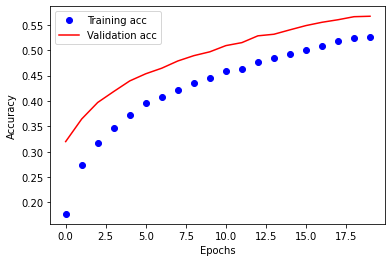

When learning_rate = 0.000100:
  When mode is CNNModel1:
Epoch 1/20
1250/1250 [==============================] - 20s 15ms/step - loss: 1.7368 - acc: 0.3847 - val_loss: 1.3095 - val_acc: 0.5406
Epoch 2/20
1250/1250 [==============================] - 18s 15ms/step - loss: 1.1651 - acc: 0.5851 - val_loss: 1.0711 - val_acc: 0.6257
Epoch 3/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.9661 - acc: 0.6640 - val_loss: 0.9293 - val_acc: 0.6791
Epoch 4/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.8558 - acc: 0.7045 - val_loss: 0.9153 - val_acc: 0.6957
Epoch 5/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.7724 - acc: 0.7306 - val_loss: 0.9267 - val_acc: 0.6950
Epoch 6/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.7226 - acc: 0.7507 - val_loss: 1.0786 - val_acc: 0.6703
Epoch 7/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.6722 - acc: 0.7686 - val_loss: 0.9324 - val_acc

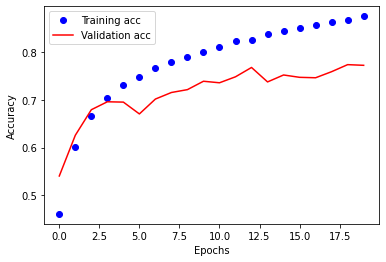

  When mode is CNNModel2:
Epoch 1/20
1250/1250 [==============================] - 8s 5ms/step - loss: 2.0596 - acc: 0.2686 - val_loss: 1.4570 - val_acc: 0.4839
Epoch 2/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.4948 - acc: 0.4641 - val_loss: 1.2954 - val_acc: 0.5451
Epoch 3/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.3335 - acc: 0.5249 - val_loss: 1.1775 - val_acc: 0.5793
Epoch 4/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2306 - acc: 0.5631 - val_loss: 1.0993 - val_acc: 0.6099
Epoch 5/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1567 - acc: 0.5863 - val_loss: 1.0362 - val_acc: 0.6277
Epoch 6/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.1119 - acc: 0.6068 - val_loss: 0.9971 - val_acc: 0.6418
Epoch 7/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.0554 - acc: 0.6277 - val_loss: 1.0705 - val_acc: 0.6237
Epoch 8/20
1250/1250 [==============

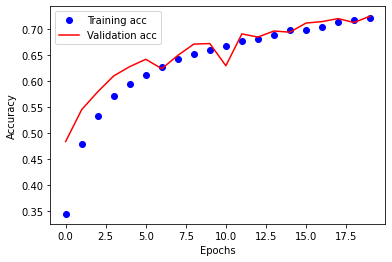

When learning_rate = 0.000300:
  When mode is CNNModel1:
Epoch 1/20
1250/1250 [==============================] - 20s 15ms/step - loss: 1.5803 - acc: 0.4418 - val_loss: 1.9592 - val_acc: 0.4523
Epoch 2/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.9588 - acc: 0.6659 - val_loss: 0.9086 - val_acc: 0.6800
Epoch 3/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.8043 - acc: 0.7203 - val_loss: 1.0127 - val_acc: 0.6623
Epoch 4/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.7081 - acc: 0.7526 - val_loss: 0.9339 - val_acc: 0.6960
Epoch 5/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.6378 - acc: 0.7822 - val_loss: 0.9733 - val_acc: 0.6940
Epoch 6/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.5804 - acc: 0.8024 - val_loss: 0.8301 - val_acc: 0.7442
Epoch 7/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.5460 - acc: 0.8110 - val_loss: 0.8178 - val_acc

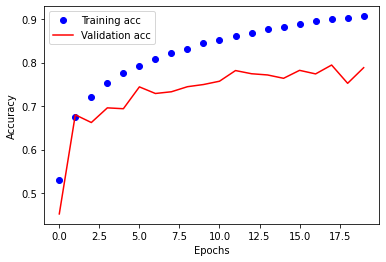

  When mode is CNNModel2:
Epoch 1/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8019 - acc: 0.3493 - val_loss: 1.2730 - val_acc: 0.5391
Epoch 2/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2803 - acc: 0.5418 - val_loss: 1.2852 - val_acc: 0.5553
Epoch 3/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1143 - acc: 0.6009 - val_loss: 1.0588 - val_acc: 0.6275
Epoch 4/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.0362 - acc: 0.6360 - val_loss: 0.9161 - val_acc: 0.6778
Epoch 5/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.9585 - acc: 0.6634 - val_loss: 0.8832 - val_acc: 0.6883
Epoch 6/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.9183 - acc: 0.6763 - val_loss: 0.8682 - val_acc: 0.6928
Epoch 7/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.8693 - acc: 0.6962 - val_loss: 1.2280 - val_acc: 0.5888
Epoch 8/20
1250/1250 [==============

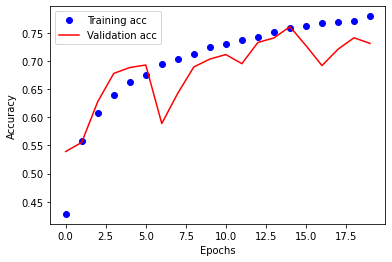

When learning_rate = 0.001000:
  When mode is CNNModel1:
Epoch 1/20
1250/1250 [==============================] - 20s 15ms/step - loss: 1.5315 - acc: 0.4550 - val_loss: 1.9277 - val_acc: 0.4856
Epoch 2/20
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9331 - acc: 0.6689 - val_loss: 1.2211 - val_acc: 0.6054
Epoch 3/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.7771 - acc: 0.7289 - val_loss: 0.8437 - val_acc: 0.7069
Epoch 4/20
1250/1250 [==============================] - 19s 15ms/step - loss: 0.6800 - acc: 0.7635 - val_loss: 0.8215 - val_acc: 0.7119
Epoch 5/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.6029 - acc: 0.7913 - val_loss: 0.7043 - val_acc: 0.7593
Epoch 6/20
1250/1250 [==============================] - 19s 15ms/step - loss: 0.5545 - acc: 0.8097 - val_loss: 0.8439 - val_acc: 0.7089
Epoch 7/20
1250/1250 [==============================] - 18s 15ms/step - loss: 0.4958 - acc: 0.8321 - val_loss: 0.9847 - val_acc

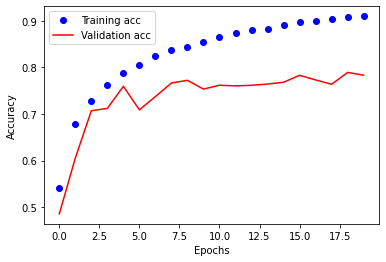

  When mode is CNNModel2:
Epoch 1/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.6217 - acc: 0.4160 - val_loss: 1.4402 - val_acc: 0.5042
Epoch 2/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1082 - acc: 0.6052 - val_loss: 1.5401 - val_acc: 0.4766
Epoch 3/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.9741 - acc: 0.6489 - val_loss: 1.0861 - val_acc: 0.6393
Epoch 4/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9028 - acc: 0.6832 - val_loss: 0.9540 - val_acc: 0.6600
Epoch 5/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8428 - acc: 0.7080 - val_loss: 1.1322 - val_acc: 0.6142
Epoch 6/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.8012 - acc: 0.7211 - val_loss: 0.8177 - val_acc: 0.7136
Epoch 7/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.7679 - acc: 0.7304 - val_loss: 1.1165 - val_acc: 0.6487
Epoch 8/20
1250/1250 [==============

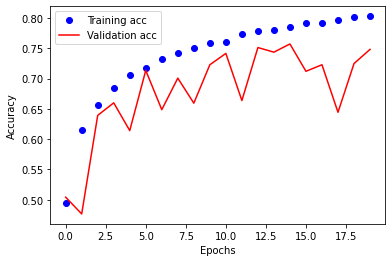

In [124]:
# tune its hyper-parameters: learning_rate, CNN structure

from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

learning_rate = [1E-5, 1E-4, 3E-4, 1E-3] # to be tuned!

for i in learning_rate:
  print('When learning_rate = %f:'%i)
  for fn in [CNNModel1, CNNModel2]:
    # fit
    print('  When mode is %s:'%(fn.__name__))
    model = fn()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=i),
                  metrics=['acc'])
    history = model.fit(x_tr, y_tr, batch_size=32, epochs=20, validation_data=(x_val, y_val))

    # plot
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
  

  

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [125]:
# choose the best hyper-paras
learning_rate = 3E-4
model = CNNModel1()

# compile
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [126]:
# <Train your model on the entire training set (50K samples)>
# <Use (x_train, y_train_vec) instead of (x_tr, y_tr)>
# <Do NOT use the validation_data option (because now you do not have validation data)>
# ...

# training by all 50K samples
history = model.fit(x_train, y_train_vec, batch_size=32, epochs=80)

Epoch 1/80
1563/1563 [==============================] - 23s 14ms/step - loss: 1.5211 - acc: 0.4572
Epoch 2/80
1563/1563 [==============================] - 22s 14ms/step - loss: 0.9325 - acc: 0.6754
Epoch 3/80
1563/1563 [==============================] - 22s 14ms/step - loss: 0.7662 - acc: 0.7331
Epoch 4/80
1563/1563 [==============================] - 22s 14ms/step - loss: 0.6844 - acc: 0.7616
Epoch 5/80
1563/1563 [==============================] - 22s 14ms/step - loss: 0.6346 - acc: 0.7803
Epoch 6/80
1563/1563 [==============================] - 22s 14ms/step - loss: 0.5834 - acc: 0.8012
Epoch 7/80
1563/1563 [==============================] - 22s 14ms/step - loss: 0.5366 - acc: 0.8179
Epoch 8/80
1563/1563 [==============================] - 22s 14ms/step - loss: 0.5028 - acc: 0.8274
Epoch 9/80
1563/1563 [==============================] - 22s 14ms/step - loss: 0.4726 - acc: 0.8392
Epoch 10/80
1563/1563 [==============================] - 22s 14ms/step - loss: 0.4350 - acc: 0.8503
Epoch 11/

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [127]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 2s 5ms/step - loss: 0.8224 - acc: 0.8265
loss = 0.8224384784698486
accuracy = 0.8264999985694885
